 # **Overview**

We are a marketing consulting company named Emo-Vector LLC that specializes in marketing insights derived from emotion. We aim to expand the reach of emerging Asian consumer electronics companies such as Samsung, Xiaomi, Oppo, and Vivo by utilizing targeted online advertising. We hope to use the power of big data to create a model that can swiftly and efficiently target consumers who have non-positive emotions towards brand competitors such as Apple and Google.

Our presentation, where we analyze our dataset can be found at: "Consumer Sentiment Analysis"

 # **Business Problem**


Advertising efforts are not tailored to consumer emotions.
Budget is wasted on non-receptive consumers.
Using our machine learning model we aim to identify consumers expressing non-positive emotions toward competitor brands for targeted online advertising efforts.
 
It’s essential to understand the feelings of the customers. 
By understanding these sentiments, a company can make data-driven 
decisions and target digital advertising to consumers with non-positive 
feelings toward competitor brands.


 # **Data Understanding**

We are sourcing the data for this project from Twitter which can be found at Phase4_tweet_dataset.csv in the data folder in the GitHub repository. We analyzed 9,092 tweets during the South by Southwest music festival. Our visualizations can also be found seperately in the Images folder located in this repository. We will analyze a list of variables from Twitter data set such as the individual tweet text, the product at which the tweet is directed, and a target variable of positive, negative, or neutral emotion tweets. Limitations of the data include class imbalance, where only 33% of our data points are considered positive tweets (67% non-positive). Also, a vast majority of the tweets within the data set are neutral emotion, therefore limiting the ability of the model to learn positive and negative emotions.

### Optional Installs

In [110]:
#!pip install nltk
#!conda install -c anaconda nltk
# pip install wordcloud

### Import statements

In [163]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import numpy as np
import seaborn as sns
import re

from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer, regexp_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier


from string import digits
from imblearn.over_sampling import SMOTE

### Downloads

In [112]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

### Data import

In [113]:
df = pd.read_csv('Data/Phase4_tweet_dataset.csv', encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Data cleaning

In [114]:
#helper function to create binary label
def change_label(label):
    if label != 'Positive emotion':
        label = "Non-positive emotion"
    return label

In [115]:
#label column
df['binary_label'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(change_label)

In [116]:
#dropping na value from tweet_text column
df_original = df[df['tweet_text'].isna() != True].copy()

In [117]:
df_original.shape

(9092, 4)

### Preprocessing

In [118]:
#creating stopwords
sw = stopwords.words('english')
sw.extend(["i'd", "i'm", "w", "@mention", "#sxswrt", "#ipad", "#apple", "u", "#sxsw", "sxsw", "mention", "ipad", "apple", "iphone", "link", "rt", "google", "quot", "linkrt", "amp", "austin"])

In [119]:
##Translate nltk POS to wordnet tags for lemmatizer
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [120]:
# preparer function to tokenize, remove punctuation, lemmatize, and get rid of numerics
def doc_preparer(doc, stop_words=sw):
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    
#     tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
#     doc = tweet_tokenizer.tokenize(doc)
    
    doc = [word for word in doc if word not in sw] #getting rid of stopwords
    doc = [word for word in doc if string.punctuation.find(word) == -1] #getting rid of punctuation
    
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]

    lemmatizer = WordNetLemmatizer() #lemmatizing
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc] 
    doc = [re.sub(r"\d+", "", word) for word in doc] #getting rid of numeric values
        
    return ' '.join(doc)   

In [121]:
# creating clean_tweets column
df_original['clean_tweets'] = df_original['tweet_text'].apply(doc_preparer)

In [122]:
df_original.head(1)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,binary_label,clean_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Non-positive emotion,wesley g hr tweet rise dead need upgrade plugi...


### Visualizing words

In [123]:
#body of text
corpus = ''
for i in df_original['clean_tweets'][:]:
    corpus += i

''

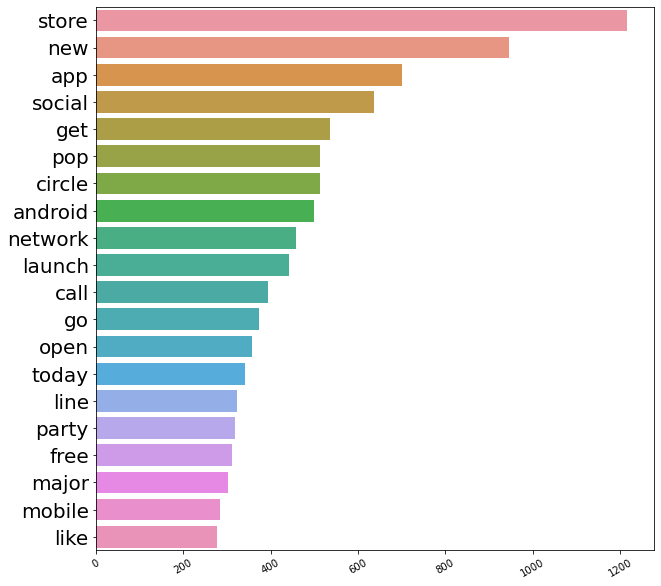

In [124]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(corpus.split()).most_common(20)
## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))
## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist.index, x=all_fdist.values, ax=ax, orient='h')
plt.xticks(rotation=30)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=20) 
plt.savefig('clean_tweets_distro')
;

### Vectorizing

In [125]:
##creating our X and y variables before our train test split
X = df_original.drop(columns=['is_there_an_emotion_directed_at_a_brand_or_product', 'tweet_text', 'binary_label', 'emotion_in_tweet_is_directed_at'], axis =1)
y = df_original['binary_label']

In [126]:
##running our train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [127]:
##utilizing our CountVectorizer to transform values to numerical
cv = CountVectorizer(input='content') #ngram_range=(3, 500)

In [128]:
##vectorizing our training data
X_train_vec = cv.fit_transform(X_train['clean_tweets'])
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [129]:
##vectorizing our test data
X_test_vec = cv.transform(X_test['clean_tweets'])
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)


### Dummy classifier

In [132]:
##checking our dummy/base model score
dc = DummyClassifier(strategy='stratified')
dc.fit(X_train_vec, y_train)

print(cross_val_score(dc, X_train_vec, y_train).mean())

0.5670932456651814


### Naive Bayes

In [133]:
##introducing a more complex model to compare to dummy model
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
mnb_pred = mnb.predict(X_test_vec)

print(cross_val_score(mnb, X_train_vec, y_train).mean())
print("Recall", recall_score(y_test, mnb_pred, pos_label="Non-positive emotion"))
print("Accuracy", accuracy_score(y_test, mnb_pred))

0.7036200764657916
Recall 0.813907284768212
Accuracy 0.7061152661680599


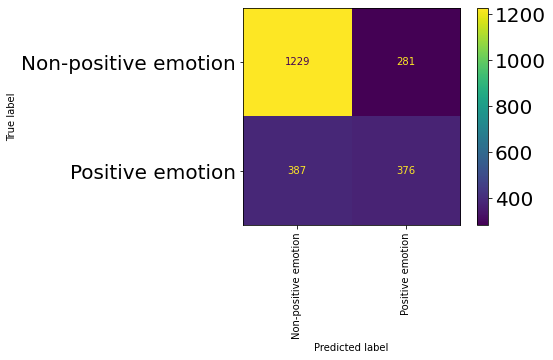

In [134]:
#Confusion matrix of Naive Bayes
plot_confusion_matrix(mnb, X_test_vec, y_test, xticks_rotation='vertical');

In [135]:
#introducing another complex model to compare scores
sgd = SGDClassifier(penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None, n_iter_no_change=20)
sgd.fit(X_train_vec, y_train)
sgd_pred = sgd.predict(X_train_vec)
sgd_pred_test = sgd.predict(X_test_vec)
print("Cross validation", cross_val_score(sgd, X_train_vec, y_train).mean())
print("Recall", recall_score(y_test, sgd_pred_test, pos_label="Non-positive emotion"))
print("Accuracy", accuracy_score(y_test, sgd_pred_test))
print("Precision", precision_score(y_test, sgd_pred_test, pos_label="Non-positive emotion"))

Cross validation 0.7366159046264602
Recall 0.8960264900662251
Accuracy 0.7179938407391113
Precision 0.7365269461077845


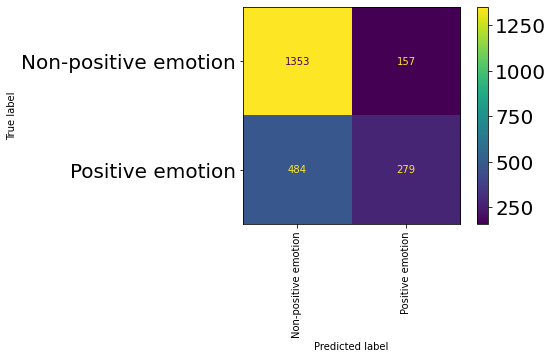

In [136]:
#SGD confusion matrix, bad performance on positive emotion with 63% misclassified 
plot_confusion_matrix(sgd, X_test_vec, y_test, xticks_rotation='vertical');

### Non-positive words vizualization

In [137]:
#filtering non-positive tweets
non_positive_tweets = df_original[df_original['is_there_an_emotion_directed_at_a_brand_or_product']  != 'Positive emotion']['clean_tweets']

In [138]:
#body of non-positive words
corpus_pos = ''
for i in non_positive_tweets:
    corpus_pos += i

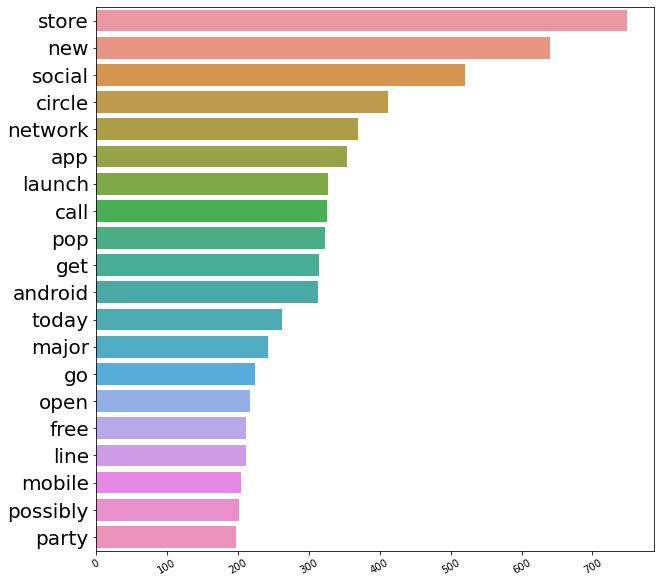

In [139]:
all_fdist1 = FreqDist(corpus_pos.split()).most_common(20)
## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist1 = pd.Series(dict(all_fdist1))
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))
## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist1.index, x=all_fdist1.values, ax=ax, orient='h')
plt.xticks(rotation=30)

plt.savefig('new_non_positive');

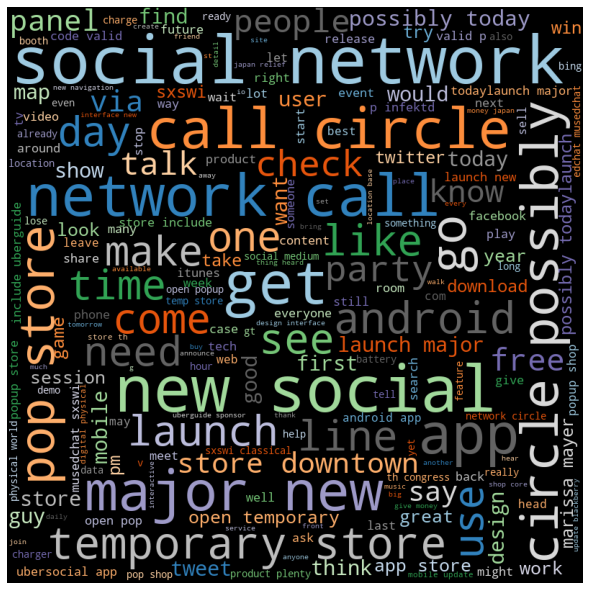

''

In [141]:
#Creating Wordcloud of most frequent words in non-positive tweets
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
    
wordcloud = WordCloud(width = 800, height = 800,
                colormap="tab20c",
                stopwords = sw,
                min_font_size = 10).generate(corpus_pos)
 
# plot the WordCloud image            


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('new_non_pos_word_cloud1')
plt.show()
;

### Testing SMOTE

In [142]:
##preproccessing data to get dataset ready for SMOTE
X_train_ind = X_train_vec.reset_index(drop=True)
y_train_ind = y_train.reset_index(drop= True)

In [143]:
##preproccessing data to get dataset ready for SMOTE
y_train_inds = y_train_ind.to_numpy()
y_train_inds

array(['Non-positive emotion', 'Non-positive emotion', 'Positive emotion',
       ..., 'Non-positive emotion', 'Positive emotion',
       'Non-positive emotion'], dtype=object)

In [144]:
##preproccessing data to get dataset ready for SMOTE
X_train_inds = X_train_ind.to_numpy()

In [145]:
#Initializing SMOTE
smote = SMOTE(random_state = 11, sampling_strategy='auto')
X_train_sm, y_train_sm = smote.fit_resample(X = X_train_inds, y = y_train_inds)

In [147]:
#SMOTED VALUES DECREASE THE PERFORMANCE OF THE MODEL
sgd1 = SGDClassifier(penalty='l1', alpha=1e-3, random_state=42, max_iter=10, tol=None)
sgd1.fit(X_train_sm, y_train_sm)
sgd_pred1 = sgd1.predict(X_test_vec)
print("Recall", recall_score(y_test, sgd_pred1, average='weighted'))
print("Accuracy", accuracy_score(y_test, sgd_pred1))

Recall 0.5736911570611527
Accuracy 0.5736911570611527


### ExtraTreesClassifier model

In [148]:
#introducing another complex model to compare scores
etc = ExtraTreesClassifier()
etc.fit(X_train_vec, y_train)

ExtraTreesClassifier()

In [149]:
etc_predict = etc.predict(X_test_vec)

In [153]:
#Best performance so far
print("Cross validation", cross_val_score(etc, X_train_vec, y_train).mean())
print("Recall", recall_score(y_test, etc_predict, pos_label="Non-positive emotion"))
print("Accuracy", accuracy_score(y_test, etc_predict))
print("Precision", precision_score(y_test, etc_predict, pos_label="Non-positive emotion"))

Cross validation 0.7247371353943669
Recall 0.8516556291390729
Accuracy 0.7294324681038276
Precision 0.7668455575432319


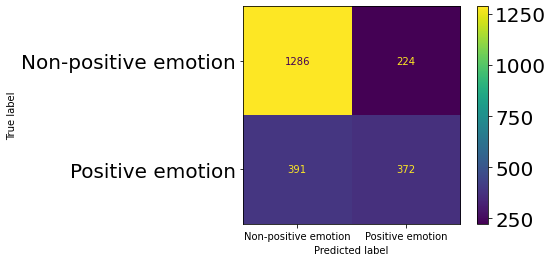

In [151]:
#confusion matrix for ExtraTreesClasifier
plot_confusion_matrix(etc, X_test_vec, y_test)

### ExtraTreesClassifier grid search

In [154]:
from sklearn.model_selection import GridSearchCV

In [114]:
# grid = {'n_estimators':range(100, 120), 'criterion': ["gini", "entropy"], 'min_samples_split':range(2,5)}

# etcgrid = GridSearchCV(estimator=etc, param_grid=grid, cv=5, n_jobs=-4, verbose=3)
# etcgrid.fit(X_train_vec, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done  22 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-4)]: Done 118 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-4)]: Done 278 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-4)]: Done 502 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-4)]: Done 600 out of 600 | elapsed: 50.5min finished


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(100, 120)},
             verbose=3)

Best parameters

In [115]:
# etcgrid.best_params_
# {'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 106}


{'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 106}

In [155]:
#best estimator from gridsearch
etc_best_par = ExtraTreesClassifier(criterion = 'entropy', min_samples_split = 4, n_estimators = 106)

In [156]:
etc_best_par.fit(X_train_vec, y_train)

ExtraTreesClassifier(criterion='entropy', min_samples_split=4, n_estimators=106)

1% increase in accuracy is not worth 2 percent loss in positive emotion recall score
compared to ExtraTreesClassifier with default hyperparameters

In [161]:
#Checking metrics
etc_best_pred = etc_best_par.predict(X_test_vec)
print("Cross validation", cross_val_score(etc, X_train_vec, y_train).mean())
print("Recall of non-positive", recall_score(y_test, etc_best_pred, pos_label="Non-positive emotion"))
print("Recall of positive", recall_score(y_test, etc_best_pred, pos_label="Positive emotion"))
print("Accuracy", accuracy_score(y_test, etc_best_pred))
print("Precision", precision_score(y_test, etc_best_pred, pos_label="Non-positive emotion"))

Cross validation 0.7220979467837678
Recall of non-positive 0.8543046357615894
Recall of positive 0.47313237221494103
Accuracy 0.7263528376594809
Precision 0.7624113475177305


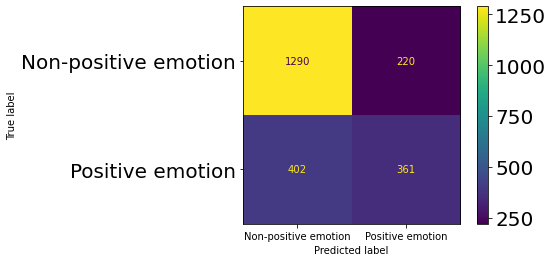

In [164]:
##grid searched ETC confusion matrix
plot_confusion_matrix(etc_best_par, X_test_vec, y_test)

### Comparison of all models performance metrics and chosing the best.

In [175]:
print("ExtraTrees with Gridsearch best parameters")
print(classification_report(y_test, etc_best_pred))

ExtraTrees with Gridsearch best parameters
                      precision    recall  f1-score   support

Non-positive emotion       0.76      0.85      0.81      1510
    Positive emotion       0.62      0.47      0.54       763

            accuracy                           0.73      2273
           macro avg       0.69      0.66      0.67      2273
        weighted avg       0.72      0.73      0.72      2273



In [177]:
print("ExtraTrees with default parameters")
print(classification_report(y_test, etc_predict))

ExtraTrees with default parameters
                      precision    recall  f1-score   support

Non-positive emotion       0.77      0.85      0.81      1510
    Positive emotion       0.62      0.49      0.55       763

            accuracy                           0.73      2273
           macro avg       0.70      0.67      0.68      2273
        weighted avg       0.72      0.73      0.72      2273



In [180]:
print("Stochastic gradient descent")
print(classification_report(y_test, sgd_pred_test))

Stochastic gradient descent
                      precision    recall  f1-score   support

Non-positive emotion       0.74      0.90      0.81      1510
    Positive emotion       0.64      0.37      0.47       763

            accuracy                           0.72      2273
           macro avg       0.69      0.63      0.64      2273
        weighted avg       0.70      0.72      0.69      2273



In [181]:
print("Naive Bayes")
print(classification_report(y_test, mnb_pred))

Naive Bayes
                      precision    recall  f1-score   support

Non-positive emotion       0.76      0.81      0.79      1510
    Positive emotion       0.57      0.49      0.53       763

            accuracy                           0.71      2273
           macro avg       0.67      0.65      0.66      2273
        weighted avg       0.70      0.71      0.70      2273



ExtraTreesClassifier is chosen as the best model with the optimal tradeoff between Positive and Non-positive emotions recall score

# **Conclusion**

Our model ExtraTreesClassifier is a tool that helps to:

- Predict tweet sentiment based on the tweet text
- Target consumers who express non-positive emotions towards competitor brands
- Tailor online advertisements to those consumers efficiently 

Recall of Non-positive emotion sentiments is 85%
Recall of Positive emotion sentiments is 49%
Accuracy score on Non-positive emotion sentiment is 73%.